In [1]:
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter
from biodatatools.utils.common import json_load
from mphelper import ProcessWrapPool
from openpyxl import load_workbook
import itertools
from biodata.delimited import DelimitedWriter
import matplotlib.lines as mlines
import sys
from pathlib import Path
import pybedtools
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
import cairosvg
import re

In [2]:
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9
lw = 0.8

In [3]:
sys.path.append(str(Path.cwd().parent))
import utils

In [4]:
PROJECT_DIR_d = "/home/yc2553/projects/HEA/databases/"
PROJECT_DIR_d2 = "/fs/cbsuhy02/storage/yc2553/yc2553/databases/"
PROJECT_DIR_s = "/fs/cbsuhy02/storage/yc2553/yc2553/softwares/"
PROJECT_DIR_s2 = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/"
PROJECT_DIR_o = "/home/yc2553/projects/HEA/output/"
PROJECT_DIR_o2 = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"

# DE analysis (T1D vs. normal T cells)

## Run DESeq2

In [5]:
labels = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/classifications.json")

In [12]:
samples = [s for s in labels if "T cells" in labels[s][0]]

In [17]:
# Get differentially expressed elements between T1D and normal T cells

results = ["T1D" if "T1D" in labels[s][0] else "Normal" for s in samples]
df = pd.DataFrame(results, index=samples, columns=["Condition"])
outputfile = f"{PROJECT_DIR_o}DE/T1D/samples.txt"
df.to_csv(outputfile, sep="\t")

In [21]:
ps = ["divergent", "unidirectional"]
ds = ["distal", "proximal"]

In [9]:
# Keep elements found in these samples

outputfile = f"{PROJECT_DIR_o}DE/T1D/elements.bed"
es = {}
with DelimitedWriter(outputfile) as dw:
	for p, d in itertools.product(ps, ds):
		df = pd.read_table(f"{PROJECT_DIR_d}PROcap/processed/binary_{p}_{d}.txt", index_col=0)
		es[(p,d)] = set(df[df[samples].sum(axis=1) >= 1].index)
		for e in es[(p,d)]:
			dw.write(e.split("_"))

In [98]:
# Get raw counts

df = pd.read_table(f"{PROJECT_DIR_d}PROcap/processed/raw_reads_all.txt", index_col=0)
df_filtered = df[samples].loc[[e for k in es for e in es[k]]]
outputfile = f"{PROJECT_DIR_o}DE/T1D/raw_reads.txt"
df_filtered.to_csv(outputfile, sep="\t")

In [ ]:
# Run DESeq2 analysis in Data_preprocessing/2-2.DESeq2.ipynb

In [23]:
p = "divergent"
d = "distal"
res = pd.read_table(f"{PROJECT_DIR_o}DE/T1D/DESeq2.txt")
res = res.dropna()
res = res.loc[[e for e in list(res.index) if e in es[(p,d)]]]
res.head(2)

,baseMean,log2FoldChange,lfcSE,pvalue,padj
chr15_57587127_57587385,102.617605,0.362976,0.684459,0.466061,0.590086
chr12_69157104_69157361,13.087322,0.633950,0.518364,0.146310,0.252750


In [25]:
padj_cutoff = 0.05
lfc_cutoff = 1
conditions = [
	(res["padj"] < padj_cutoff) & (res["log2FoldChange"] > lfc_cutoff),
	(res["padj"] < padj_cutoff) & (res["log2FoldChange"] < -lfc_cutoff),
]
ks = ["Up", "Down"]
res["Label"] = np.select(conditions, ks, default="Unchanged")
Counter(res["Label"])

Counter({'Unchanged': 15290, 'Down': 4083, 'Up': 1744})

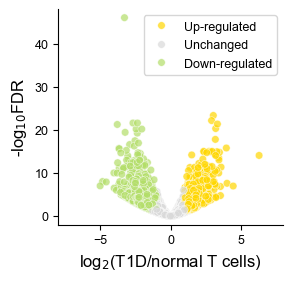

In [35]:
fig, ax = plt.subplots(figsize=(2.9,2.8))
res["-log10padj"] = -np.log10(res["padj"])
g = sns.scatterplot(data=res, x="log2FoldChange", y="-log10padj", 
					hue="Label", hue_order=["Up", "Unchanged", "Down"],
					palette=["#FFD700","#d9d9d9","#b3de69"], 
					alpha=0.7, s=30, ax=ax)
g.spines[["right", "top"]].set_visible(False)

g.set_yticks([0,10,20,30,40])
g.set_ylim([-2,48])
g.set_ylabel("-log$_{10}$FDR", fontsize=bfontsize)

g.set_xlim([-8, 8])
g.set_xlabel("log$_2$(T1D/normal T cells)", fontsize=bfontsize)

g.tick_params(labelsize=sfontsize)

handles, _ = g.get_legend_handles_labels()
g.legend(handles, ["Up-regulated", "Unchanged", "Down-regulated"], fontsize=sfontsize)
	
plt.savefig(f"{PROJECT_DIR_o}figures/Fig3e.png", bbox_inches="tight", dpi=300, transparent=True) 

# Motif enrichment

In [18]:
# Use all divergent distal elements found in these samples as background

outputfile = f"{PROJECT_DIR_o}homer/T1D/bg.bed"
utils.generate_homer_input([e for e in es[(p,d)]], outputfile)

In [124]:
for k in ks:
	outputfile = f"{PROJECT_DIR_o}homer/T1D/{k}.bed"
	es = list(res[res["Label"]==k].index)
	utils.generate_homer_input(es, outputfile)

In [23]:
pwpool = ProcessWrapPool(len(ks))

homer_dir = f"{PROJECT_DIR_s}homer/"
bg = f"{PROJECT_DIR_o}homer/T1D/bg.bed"
for k in ks:
	target = f"{PROJECT_DIR_o}homer/T1D/{k}.bed"
	outdir = f"{PROJECT_DIR_o}homer/T1D/{k}"
	pwpool.run(utils.run_homer, args=[homer_dir, target, bg, outdir])

In [44]:
len(pwpool.finished_tasks)

2

In [45]:
pwpool.close()

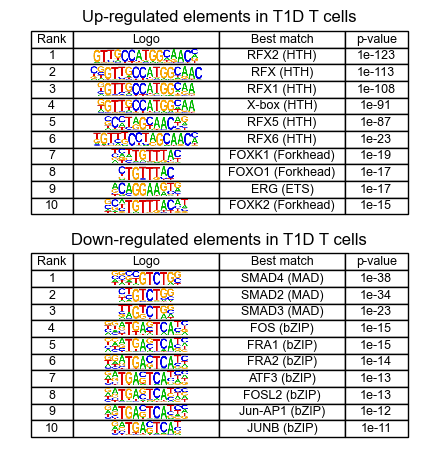

In [93]:
results = defaultdict(list)
for k in ks:
	df = pd.read_table(f"{PROJECT_DIR_o}homer/T1D/{k}/knownResults.txt").head(10)
	for i, row in df.iterrows():
		text = row["Motif Name"].split("/")[0]
		if "X-box" not in text:
			motif = re.sub(r"([A-Za-z0-9]+)\(", lambda m: m.group(1).upper() + " (", text)
		else:
			motif = re.sub(r"([A-Za-z0-9]+)\(", lambda m: m.group(1) + " (", text)
		svg_path = f"{PROJECT_DIR_o}homer/T1D/{k}/knownResults/known{i+1}.logo.svg"
		png_path = svg_path.replace(".svg", ".png")
		cairosvg.svg2png(url=svg_path, write_to=png_path)
		pval = f"{row['P-value']:.0e}".replace("e-0", "e-")
		results[k].append([i + 1, png_path, motif, pval])

fig, axes = plt.subplots(len(ks), 1, figsize=(5.4, 5.3))

for ax, k in zip(axes, ks):
	ax.axis('off')
	ax.set_title(f"{k}-regulated elements in T1D T cells", fontsize=bfontsize, y=1)
	
	table_data = [[r, '', m, p] for r, _, m, p in results[k]]
	table = ax.table(
		cellText=table_data,
		colLabels=["Rank", "Logo", "Best match", "p-value"],
		cellLoc='center',
		loc='center',
		colWidths=[0.1, 0.35, 0.3, 0.15]
	)
	table.auto_set_font_size(False)
	table.set_fontsize(sfontsize)
	fig.canvas.draw()
	
	for i, (_, img_path, _, _) in enumerate(results[k]):
		img = mpimg.imread(img_path)
		imagebox = OffsetImage(img, zoom=0.2)
		cell = table[(i + 1, 1)]
		bbox = cell.get_window_extent(fig.canvas.get_renderer())
		(x0, y0), (x1, y1) = ax.transData.inverted().transform([(bbox.x0, bbox.y0), (bbox.x1, bbox.y1)])
		x = (x0 + x1) / 2
		y = (y0 + y1) / 2
		ab = AnnotationBbox(imagebox, (x, y), frameon=False, box_alignment=(0.5, 0.5))
		ax.add_artist(ab)

plt.savefig(f"{PROJECT_DIR_o}figures/ExtDataFig6a.pdf", bbox_inches="tight", transparent=True) 

In [133]:
# Write the content of all motifs in "knownResults.html"

outputfile = f"{PROJECT_DIR_o}tables/SuppTable3.xlsx"
book = load_workbook(outputfile)
with pd.ExcelWriter(outputfile, engine='openpyxl') as f:
	for k in ks:
		html = f"{PROJECT_DIR_o}homer/T1D/{k}/knownResults.html"
		df = pd.read_html(html, header=0)[0]
		columns_keep = [c for c in df.columns if c not in ["Motif", "Motif File", "SVG"]]
		df = df[columns_keep]
		df = df[~df["Rank"].astype(str).str.contains(r"\*", na=False)]
		df.to_excel(f, sheet_name=f"T1D-{k}", index=False)

# Functional enrichment of gene sets

## Get target genes

In [38]:
# Expressed genes: genes with proximal elements (at least in one sample within the same group) as a proxy

d = "proximal"
for k in ks:
	samples2 = [s for s in samples if "T1D" in labels[s][0]] if k == "Up" else [s for s in samples if "T1D" not in labels[s][0]]
	es = set()
	for p in ps:
		df = pd.read_table(f"{PROJECT_DIR_d}PROcap/processed/binary_{p}_{d}.txt", index_col=0)
		es |= set(df[df[samples2].sum(axis=1) >= 1].index)
	outputfile = f"{PROJECT_DIR_o}DE/T1D/{k}_{d}.bed"
	with DelimitedWriter(outputfile) as dw:
		for e in es:
			dw.write(e.split("_"))

In [42]:
# Assign proximal elements to genes

expressed_genes = defaultdict(set)
b1 = pybedtools.BedTool(f"{PROJECT_DIR_s2}ABC-Enhancer-Gene-Prediction/reference/hg38/CollapsedGeneBounds.hg38.TSS500bp.bed")
for k in ks:
	b2 = pybedtools.BedTool(f"{PROJECT_DIR_o}DE/T1D/{k}_{d}.bed").sort()
	overlap = b2.intersect(b1, wao=True)
	# Keep the record with the largest overlap
	mapping = {}
	for i in overlap:
		if int(i.fields[-1]) > 0:
			e = ("_".join(i.fields[:3]))
			if e not in mapping:
				# gene, overlap length
				mapping[e] = (i.fields[6], int(i.fields[-1]))
			elif int(i.fields[-1]) > mapping[e][1]:
				mapping[e] = (i.fields[6], int(i.fields[-1]))
	expressed_genes[k] = set([mapping[e][0] for e in mapping])

In [43]:
# Get genomic coordinates of expressed genes

df = pd.read_table(f"{PROJECT_DIR_s2}ABC-Enhancer-Gene-Prediction/reference/hg38/CollapsedGeneBounds.hg38.TSS500bp.bed", header=None)
bg_genes = defaultdict(set)
for k in ks:
	bg_genes[k] = [g for g in df[3] if g in expressed_genes[k]]
	df2 = df[df[3].isin(bg_genes[k])]
	outputfile = f"{PROJECT_DIR_o}DE/T1D/expressed_genes_{k}.bed"
	df2.to_csv(outputfile, header=None, index=False, sep="\t")
	print(k, len(bg_genes[k]))

Up 9953
Down 10799


In [44]:
# Assign elements to the closest expressed genes

b1 = pybedtools.BedTool(f"{PROJECT_DIR_o}DE/T1D/elements.bed").sort()
for k in ks:
	b2 = pybedtools.BedTool(f"{PROJECT_DIR_o}DE/T1D/expressed_genes_{k}.bed").sort()
	closest = b1.closest(b2)
	closest.saveas(f"{PROJECT_DIR_o}DE/T1D/closest_genes_{k}.bed")

In [45]:
e2g_closest = defaultdict(dict)
for k in ks:
	df = pd.read_table(f"{PROJECT_DIR_o}DE/T1D/closest_genes_{k}.bed", header=None)
	for _, row in df.iterrows():
		e = "_".join([row[0], str(row[1]), str(row[2])])
		gene = row[6]
		e2g_closest[k][e] = gene

## Pathway enrichment

In [46]:
# Closest genes for DE elements

genes = defaultdict(set)
for k in ks:
	es = list(res[res["Label"]==k].index)
	for e in es:
		genes[k].add(e2g_closest[k][e])
	print(k, len(genes[k]))

Up 1102
Down 2091


In [47]:
gmt = f"{PROJECT_DIR_d2}GSEA/c5.go.bp.v2024.1.Hs.symbols.gmt"
df_merge = utils.run_enrichr(ks, gmt, genes, bg_genes)

2025-09-21 00:46:49,544 [INFO] User defined gene sets is given: /fs/cbsuhy02/storage/yc2553/yc2553/databases/GSEA/c5.go.bp.v2024.1.Hs.symbols.gmt
2025-09-21 00:46:49,710 [INFO] Run: c5.go.bp.v2024.1.Hs.symbols.gmt 
2025-09-21 00:46:49,712 [INFO] ['SERPINB6', 'TRIB1', 'QSOX2', 'ARL4C']
2025-09-21 00:46:49,713 [INFO] ['ADPRHL2', 'CYTH2', 'KIAA1324', 'ZNF589']
2025-09-21 00:46:51,638 [INFO] Done.
2025-09-21 00:46:51,671 [INFO] User defined gene sets is given: /fs/cbsuhy02/storage/yc2553/yc2553/databases/GSEA/c5.go.bp.v2024.1.Hs.symbols.gmt
2025-09-21 00:46:51,870 [INFO] Run: c5.go.bp.v2024.1.Hs.symbols.gmt 
2025-09-21 00:46:51,876 [INFO] ['ADPRHL2', 'ZNF589', 'NANS', 'PPP5D1']
2025-09-21 00:46:51,879 [INFO] ['ADPRHL2', 'CYTH2', 'KIAA1324', 'ZNF589']
2025-09-21 00:46:53,876 [INFO] Done.


In [48]:
list(df_merge[df_merge["Group"]=="Down"].sort_values(by="-log10(padj)", ascending=False)["Term"])[:15]

['GOBP_LYMPHOCYTE_ACTIVATION',
 'GOBP_CELL_ACTIVATION',
 'GOBP_T_CELL_ACTIVATION',
 'GOBP_T_CELL_DIFFERENTIATION',
 'GOBP_REGULATION_OF_IMMUNE_SYSTEM_PROCESS',
 'GOBP_LYMPHOCYTE_DIFFERENTIATION',
 'GOBP_DEFENSE_RESPONSE',
 'GOBP_ALPHA_BETA_T_CELL_DIFFERENTIATION',
 'GOBP_HEMOPOIESIS',
 'GOBP_NEGATIVE_REGULATION_OF_RNA_BIOSYNTHETIC_PROCESS',
 'GOBP_POSITIVE_REGULATION_OF_MULTICELLULAR_ORGANISMAL_PROCESS',
 'GOBP_MONONUCLEAR_CELL_DIFFERENTIATION',
 'GOBP_ADAPTIVE_IMMUNE_RESPONSE',
 'GOBP_REGULATION_OF_CELL_ACTIVATION',
 'GOBP_ALPHA_BETA_T_CELL_ACTIVATION']

In [49]:
list(df_merge[df_merge["Group"]=="Up"].sort_values(by="-log10(padj)", ascending=False)["Term"])[:15]

['GOBP_CELL_ACTIVATION',
 'GOBP_MONONUCLEAR_CELL_DIFFERENTIATION',
 'GOBP_HEMOPOIESIS',
 'GOBP_LEUKOCYTE_DIFFERENTIATION',
 'GOBP_LYMPHOCYTE_DIFFERENTIATION',
 'GOBP_LYMPHOCYTE_ACTIVATION',
 'GOBP_CIRCULATORY_SYSTEM_DEVELOPMENT',
 'GOBP_REGULATION_OF_IMMUNE_SYSTEM_PROCESS',
 'GOBP_CELL_ADHESION',
 'GOBP_NEGATIVE_REGULATION_OF_MULTICELLULAR_ORGANISMAL_PROCESS',
 'GOBP_B_CELL_ACTIVATION',
 'GOBP_VASCULATURE_DEVELOPMENT',
 'GOBP_POSITIVE_REGULATION_OF_MULTICELLULAR_ORGANISMAL_PROCESS',
 'GOBP_REGULATION_OF_CELL_ADHESION',
 'GOBP_REGULATION_OF_MULTICELLULAR_ORGANISMAL_DEVELOPMENT']

In [50]:
selected_terms = ['GOBP_B_CELL_ACTIVATION',
				  'GOBP_T_CELL_ACTIVATION',
				  'GOBP_T_CELL_DIFFERENTIATION',
				  'GOBP_ADAPTIVE_IMMUNE_RESPONSE'
				  ]

In [51]:
def format_term(t):
    phrase = " ".join(t.split("_")[1:]).capitalize()
    return phrase

In [59]:
order = [format_term(term) for term in selected_terms]
df_top = df_merge[df_merge["Term"].isin(selected_terms)].copy()
df_top["Term"] = df_top["Term"].map(format_term)
df_top["Term"] = pd.Categorical(df_top["Term"], categories=order, ordered=True)
df_top.head(2)

,Group,Term,Gene ratio,Gene count,Adjusted P-value,-log10(padj)
271,Up,B cell activation,0.264045,178.0,0.000004,5.443286
5242,Up,T cell activation,0.203166,379.0,0.000021,4.674505


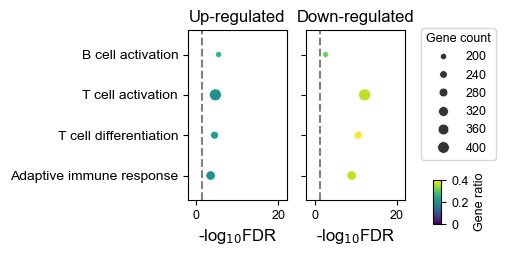

In [60]:
vlims=[0,0.2,0.4]
fig, axes = plt.subplots(1, 2, figsize=(2.8, 2.2))
for ax, k in zip(axes, ks):
	ax.set_title(f"{k}-regulated", fontsize=bfontsize)
	ax.margins(y=0.2)
	g = sns.scatterplot(
	    data=df_top[df_top["Group"]==k],
	    x="-log10(padj)",
	    y="Term",
	    size="Gene count",
		hue="Gene ratio",
		palette="viridis",
		hue_norm=(vlims[0], vlims[-1]),
		legend='brief',
		ax=ax
		)
	
	handles, labs = ax.get_legend_handles_labels()
	g.legend([], [], frameon=False)
	if ks.index(k) == 1:
		g.set_yticklabels([])
		size_handles_labels = [(h, l) for h, l in zip(handles, labs) if l.strip().isdigit()]
		size_handles, size_labels = zip(*size_handles_labels)
		g.legend(size_handles, size_labels, title="Gene count", title_fontsize=sfontsize, fontsize=sfontsize, loc="upper left", bbox_to_anchor=(1.1, 1.05))

		
		norm = plt.Normalize(vlims[0], vlims[-1])
		sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
		cbar_ax = fig.add_axes([1,0,0.03,0.2])
		cbar = plt.colorbar(sm, cax=cbar_ax)
		cbar.set_label("Gene ratio", fontsize=sfontsize)
		cbar.set_ticks(vlims)
		cbar.set_ticklabels([str(v) for v in vlims])
		cbar.ax.tick_params(labelsize=sfontsize)

	g.axvline(x=-np.log10(0.05), ls="--", c="grey")
	g.set_ylabel("")

	g.set_xlim([-2, 22])
	g.set_xlabel("-log$_{10}$FDR", fontsize=bfontsize)
	g.tick_params(axis="x", labelsize=sfontsize)

plt.savefig(f"{PROJECT_DIR_o}figures/ExtDataFig6b.pdf", bbox_inches="tight", transparent=True)

# Candidate GWAS SNPs

## Individual samples

In [6]:
snp_pos = {"rs3218258": 37148205,
			"rs228978": 37148305,
			"rs3218255": 37148446
		  }

In [7]:
order = ["Pan T cells", "Helper T cells", "Cytotoxic T cells", "T cells from T1D donor", "B cells", "NK cells", "Monocytes"]
palette = ["#fb8072", "#fdb462", "#bc80bd", "#ffed6f", "#80b1d3", "#bebada", "#b3de69"]

In [8]:
samples_keep = []
for t in order:
	samples_keep.extend([s for s in labels if labels[s][0]==t])

In [9]:
samples_dict = {}
for s in samples_keep:
	samples_dict[s] = [s]

In [10]:
rpm_bws = {}
for s in samples_keep:
	rpm_bws[s] = [f"{PROJECT_DIR_o2}rpm/{s}_{k}_rpm.bw" for k in ["pl", "mn"]]

In [11]:
region = "chr22_37147909_37148615"
df_rpm = utils.get_reads(region, rpm_bws, samples_dict)

In [12]:
strands = ["fwd", "rev"]
strand_colors = ["red", "blue"]

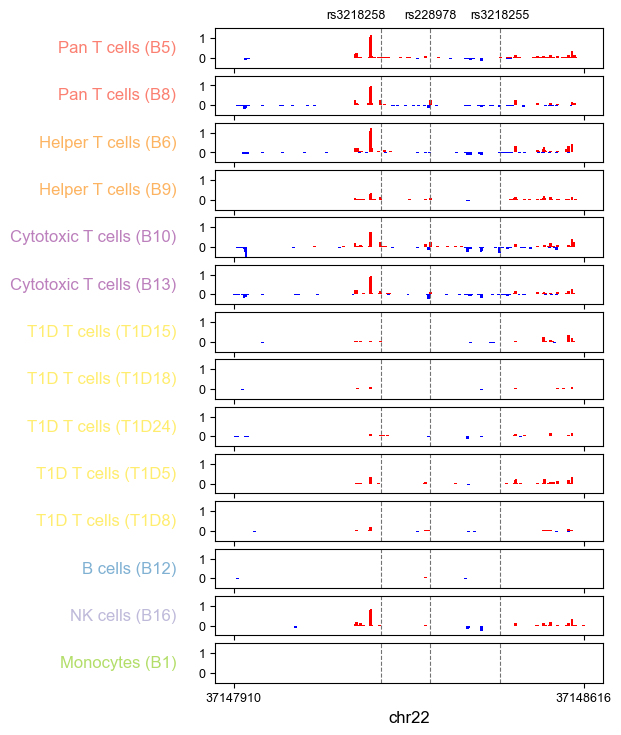

In [15]:
fig, axes = plt.subplots(len(samples_dict), 1, figsize=(5,8.5), gridspec_kw={"hspace": 0.2})

chrom, start, end = region.split("_")
start = int(start)
end = int(end)
for s in samples_dict:
	row = list(samples_dict).index(s)
	ax = axes[row]
	for k in strands:
		df = df_rpm[(df_rpm["type"]==s) & (df_rpm["orientation"]==k)]
		ax.bar(list(df["position"]), list(df["rpm"]), color=strand_colors[strands.index(k)], align='center', width=5)

	ax.ticklabel_format(useOffset=False, style='plain')
	ax.set_xticks([start, end])		
	if row == len(samples_dict)-1:
		ax.set_xticklabels([start+1, end+1])
		ax.set_xlabel(chrom, fontsize=bfontsize)
	else:
		ax.set_xticklabels([])
		
	if "T1D" in labels[s][0]:
		ylabel = f"T1D T cells ({s})"
	else:
		ylabel = f"{labels[s][0]} ({s})"
	ax.set_ylabel(ylabel, rotation=0, ha='right', va="center",
			  fontsize=bfontsize, c=palette[order.index(labels[s][0])])
	ax.yaxis.set_label_coords(-0.1, 0.5)
		
	ax.tick_params(labelsize=sfontsize)
		
	for snp in snp_pos:
		ax.axvline(x=snp_pos[snp], c="#737373", ls="--", lw=lw)
		if row == 0:
			x = snp_pos[snp]-50 if snp == "rs3218258" else snp_pos[snp]
			ax.text(x, 2, snp, ha="center", fontsize=sfontsize)

	ax.set_ylim([-0.5,1.5])
	
plt.savefig(f"{PROJECT_DIR_o}figures/ExtDataFig6c.png", bbox_inches='tight', dpi=300)

## Average across groups

In [16]:
gtf_file = f"{PROJECT_DIR_r}genomes/human/gencode.v37.annotation.gtf.gz"
gtf = pd.read_csv(
	    gtf_file,
	    sep="\t",
	    comment="#",
	    header=None,
	    names=["chrom", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"]
	)

In [17]:
samples_dict2 = defaultdict(list)
for t in ["Normal", "T1D"]:
	if t == "Normal":
		samples_dict2[t] = [s for s in samples_keep if "T cells" in labels[s][0] and "T1D" not in labels[s][0]]
	else:
		samples_dict2[t] = [s for s in samples_keep if "T1D" in labels[s][0]]

In [18]:
df_rpm2 = utils.get_reads(region, rpm_bws, samples_dict2)

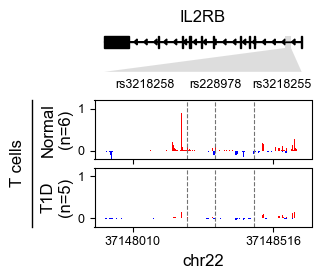

In [19]:
fig, axes = plt.subplots(len(samples_dict2)+2, 1, figsize=(2.8,2.5), height_ratios=[2,0.5,3,3])

# Gene position
for n in range(2):
	axes[n].axis("off")
utils.gene_representation("IL2RB", "ENST00000216223.10", gtf, axes[0], start, end, bfontsize, "#000000")


# Average PRO-cap signals
for g in samples_dict2:
	row = list(samples_dict2).index(g)+2
	ax = axes[row]
	for k in strands:
		df = df_rpm2[(df_rpm2["type"]==g) & (df_rpm2["orientation"]==k)]
		ax.bar(list(df["position"]), list(df["rpm"]), color=strand_colors[strands.index(k)], align='center', width=3)

	ax.ticklabel_format(useOffset=False, style='plain')
	ax.set_xticks([start+100, end-100])
	if row == len(samples_dict2)+1:
		ax.set_xlabel(chrom, fontsize=bfontsize)
		ax.set_xticklabels([start+100+1, end-100+1], fontsize=sfontsize)
	else:
		ax.set_xlabel("")
		ax.set_xticklabels([])
		
	ax.set_ylabel(f"{g}\n(n={len(samples_dict2[g])})", fontsize=bfontsize)
	ax.yaxis.set_label_coords(-0.1, 0.5)
	ax.set_ylim([-0.2,1.2])
	ax.tick_params(labelsize=sfontsize)

	for snp in snp_pos:
		ax.axvline(x=snp_pos[snp], c="#737373", ls="--", lw=lw)
		if row == 2:
			if snp == "rs3218258":
				x = snp_pos[snp]-150 
			elif snp == "rs228978":
				x = snp_pos[snp]
			else:
				x = snp_pos[snp] + 100
			ax.text(x, 1.5, snp, ha="center", fontsize=sfontsize)
		
row1, row2 = 2, 3
y_center = (axes[row1].get_position().y0 + axes[row2].get_position().y1) / 2
fig.text(-0.15, y_center, "T cells", va="center", ha="center", rotation="vertical", 
		 fontsize=bfontsize, c="black")
line = mlines.Line2D([-0.1, -0.1], [axes[row1].get_position().y1, axes[row2].get_position().y0], transform=fig.transFigure,
				 color="black", linewidth=1, zorder=10)
fig.add_artist(line)

plt.savefig(f"{PROJECT_DIR_o}figures/Fig3f.pdf", bbox_inches='tight')